## After collecting the data in the previous step, we will do text preprocessing in this step

In [1]:
!pip install transformers

  Created wheel for sacremoses: filename=sacremoses-0.0.43-py3-none-any.whl size=893262 sha256=2d5f3052ef3622ed3c9bf98785deb23e27c01ee76fb434edb531e918d73d7c01
  Stored in directory: c:\users\thakk\appdata\local\pip\cache\wheels\69\09\d1\bf058f7d6fa0ecba2ce7c66be3b8d012beb4bf61a6e0c101c0
Successfully built sacremoses


### Import libraries

In [5]:
#Libraries for Text preprocessing 
import transformers 
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

#Normal computation libraries
import pandas as pd
import numpy as np

#Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries for modelling
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict
from textwrap import wrap

#Pytorch libraries
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

#Set the Random Seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

#Check for gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Read the data

In [8]:
#Read the reviews
df = pd.read_csv('appReviews.csv')
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEito_ps2PJsih6PrHkYUoA5Oa_N2IQ2Z8ngt-...,Feng Yu,https://play-lh.googleusercontent.com/a-/AOh14...,I had an any.do account and could not add a ne...,1,8,5.6.0.8,2020-11-15 07:36:51,Users can create an account either logging in ...,2020-11-15 03:02:54,most_relevant,com.anydo
1,gp:AOqpTOEA0ubPA5n0s_6lg0BHqfQqj0gi-KIdZF_I1yZ...,Lisa Pappas,https://play-lh.googleusercontent.com/a-/AOh14...,Constant crashing. After reading all the negat...,1,18,5.6.0.6,2020-10-21 10:45:24,NaN,NaN,most_relevant,com.anydo
2,gp:AOqpTOH-vlrtfNZEnw3Kjz6q5Z27z1GKwAuVx_qVDfo...,Stacie Grimes,https://play-lh.googleusercontent.com/a-/AOh14...,The app works well at times but I've been char...,1,2,5.6.0.8,2020-11-08 20:59:19,Please note that you may cancel your subscript...,2020-11-11 02:37:04,most_relevant,com.anydo
3,gp:AOqpTOGHb-APKKMNFyL1OwuGq1AGW6bQp5aYYxSHvJx...,Gale W,https://play-lh.googleusercontent.com/a-/AOh14...,I'm only looking for a grocery list app but ev...,1,2,5.6.0.6,2020-10-25 11:10:46,Sorry about that. We are not aware of any issu...,2020-10-26 02:23:42,most_relevant,com.anydo
4,gp:AOqpTOH9y0mrXUuqulfB_d48QIXYJet79OMMr8jzm85...,John Oswald-Jacobs,https://play-lh.googleusercontent.com/-jB1fuDT...,Hopeless customer service. I paid for the prem...,1,92,5.6.0.1,2020-09-26 00:30:52,Sorry for the delay in reply! Due to adjusted ...,2020-09-27 03:50:27,most_relevant,com.anydo


In [11]:
#We will remove the id for simplicity
df.drop('reviewId', axis = 1, inplace = True)
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Feng Yu,https://play-lh.googleusercontent.com/a-/AOh14...,I had an any.do account and could not add a ne...,1,8,5.6.0.8,2020-11-15 07:36:51,Users can create an account either logging in ...,2020-11-15 03:02:54,most_relevant,com.anydo
1,Lisa Pappas,https://play-lh.googleusercontent.com/a-/AOh14...,Constant crashing. After reading all the negat...,1,18,5.6.0.6,2020-10-21 10:45:24,NaN,NaN,most_relevant,com.anydo
2,Stacie Grimes,https://play-lh.googleusercontent.com/a-/AOh14...,The app works well at times but I've been char...,1,2,5.6.0.8,2020-11-08 20:59:19,Please note that you may cancel your subscript...,2020-11-11 02:37:04,most_relevant,com.anydo
3,Gale W,https://play-lh.googleusercontent.com/a-/AOh14...,I'm only looking for a grocery list app but ev...,1,2,5.6.0.6,2020-10-25 11:10:46,Sorry about that. We are not aware of any issu...,2020-10-26 02:23:42,most_relevant,com.anydo
4,John Oswald-Jacobs,https://play-lh.googleusercontent.com/-jB1fuDT...,Hopeless customer service. I paid for the prem...,1,92,5.6.0.1,2020-09-26 00:30:52,Sorry for the delay in reply! Due to adjusted ...,2020-09-27 03:50:27,most_relevant,com.anydo


In [12]:
#Get the data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16252 entries, 0 to 16251
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              16252 non-null  object
 1   userImage             16252 non-null  object
 2   content               16252 non-null  object
 3   score                 16252 non-null  int64 
 4   thumbsUpCount         16252 non-null  int64 
 5   reviewCreatedVersion  13949 non-null  object
 6   at                    16252 non-null  object
 7   replyContent          8473 non-null   object
 8   repliedAt             8473 non-null   object
 9   sortOrder             16252 non-null  object
 10  appId                 16252 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.4+ MB


Text(0, 0.5, 'Score counts')

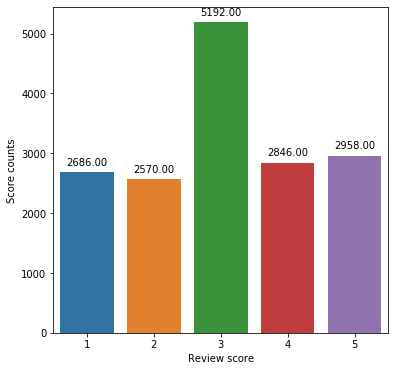

In [19]:
#We are interested in score, let's check the distribution
plt.rcParams['figure.figsize'] = 6, 6
review_count = sns.countplot(df.score)
for p in review_count.patches:
    review_count.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.xlabel("Review score")
plt.ylabel("Score counts")

Convert the score to (4 and 5 to 2)positive, (1 and 2 to 0)negative and (3 to 1)neutral 

In [20]:
def convert_score_to_sentiment(rating):
    rating = int(rating)
    
    #If negative return 0 
    if rating < 3:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

In [22]:
#Add the new column named sentiment
df['sentiment'] = df['score'].apply(convert_score_to_sentiment)
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
0,Feng Yu,https://play-lh.googleusercontent.com/a-/AOh14...,I had an any.do account and could not add a ne...,1,8,5.6.0.8,2020-11-15 07:36:51,Users can create an account either logging in ...,2020-11-15 03:02:54,most_relevant,com.anydo,0
1,Lisa Pappas,https://play-lh.googleusercontent.com/a-/AOh14...,Constant crashing. After reading all the negat...,1,18,5.6.0.6,2020-10-21 10:45:24,NaN,NaN,most_relevant,com.anydo,0
2,Stacie Grimes,https://play-lh.googleusercontent.com/a-/AOh14...,The app works well at times but I've been char...,1,2,5.6.0.8,2020-11-08 20:59:19,Please note that you may cancel your subscript...,2020-11-11 02:37:04,most_relevant,com.anydo,0
3,Gale W,https://play-lh.googleusercontent.com/a-/AOh14...,I'm only looking for a grocery list app but ev...,1,2,5.6.0.6,2020-10-25 11:10:46,Sorry about that. We are not aware of any issu...,2020-10-26 02:23:42,most_relevant,com.anydo,0
4,John Oswald-Jacobs,https://play-lh.googleusercontent.com/-jB1fuDT...,Hopeless customer service. I paid for the prem...,1,92,5.6.0.1,2020-09-26 00:30:52,Sorry for the delay in reply! Due to adjusted ...,2020-09-27 03:50:27,most_relevant,com.anydo,0


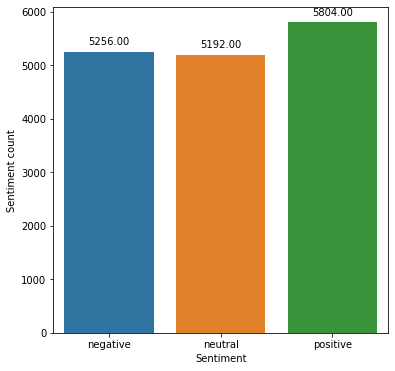

In [23]:
#Get the distribution of the sentiments
class_name = ['negative', 'neutral', 'positive']

sentiment_count = sns.countplot(df['sentiment'])
plt.xlabel('Sentiment')
plt.ylabel('Sentiment count')
sentiment_count.set_xticklabels(class_name)
for p in sentiment_count.patches:
    sentiment_count.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

The data seems balanced

### Data Preprocessing

We need to convert the text to numbers using tokenizer. For training data, BERT requires extra steps like
1. BERT needs special tokens indicating starting and ending of sentence, and special tokens for classification. 
2. The input must be of fixed length (padding for less tokens)
3. Create attention mask indicating importance of token

In [24]:
#Define the BERT Model
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'   #Cased better here for sentiment analysis might have more weight here

In [25]:
#Set the tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Perform a sample text analysis

In [26]:
#Create a sample sentence for analysis
sample = 'I love NLP. It is very interesting to play with words. Do you like NLP?'

#Get the tokens
tokens = tokenizer.tokenize(sample)
print("Sentence: ", sample)
print("Tokens: ",tokens)

#Get the ids of tokens from BERT vocab
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print("Token ids: ", token_ids)

Sentence:  I love NLP. It is very interesting to play with words. Do you like NLP?
Tokens:  ['I', 'love', 'NL', '##P', '.', 'It', 'is', 'very', 'interesting', 'to', 'play', 'with', 'words', '.', 'Do', 'you', 'like', 'NL', '##P', '?']
Token ids:  [146, 1567, 21239, 2101, 119, 1135, 1110, 1304, 5426, 1106, 1505, 1114, 1734, 119, 2091, 1128, 1176, 21239, 2101, 136]


Add special tokens

In [27]:
#Separator token
print(tokenizer.sep_token, tokenizer.sep_token_id)
#Classification token
print(tokenizer.cls_token, tokenizer.cls_token_id)
#Unknown token
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[UNK] 100


Get the encoding directly using method

In [34]:
#Get the tokens and attention masks
encoding = tokenizer.encode_plus(
    sample,
    max_length=64,
    add_special_tokens=True,   #Add SEP, CLS tokens
    return_token_type_ids=False,
    pad_to_max_length=True,   #Automatic padding
    return_attention_mask=True,
    return_tensors='pt'    #Returns pytorch tensors (tf for Tensorflow)
)

C:\Users\thakk\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [35]:
#Get the encoding details
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [36]:
#Check the encoding ids
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

64


tensor([  101,   146,  1567, 21239,  2101,   119,  1135,  1110,  1304,  5426,
         1106,  1505,  1114,  1734,   119,  2091,  1128,  1176, 21239,  2101,
          136,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])

In [38]:
#Check the attention masks (1 for important, 0 for not)
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

64


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [40]:
#Get the original word
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', 'I', 'love', 'NL', '##P', '.', 'It', 'is', 'very', 'interesting', 'to', 'play', 'with', 'words', '.', 'Do', 'you', 'like', 'NL', '##P', '?', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


One of the question is how to set the max_padding length. It is generally in multiple of 2 and greater than sentence with highest length

In [41]:
token_lens = []
#Iterate through all content of reviews
for text in df.content:
    tokens = tokenizer.tokenize(text)
    token_lens.append(len(tokens))

Text(0, 0.5, '% of counts')

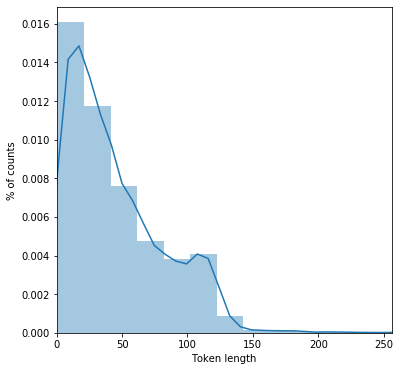

In [44]:
#Get the distribution plot
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token length')
plt.ylabel('% of counts')

We can take 128 as most of the token_length are less than 128

In [45]:
MAX_LEN =128